In [1]:
import os
import pandas as pd
from scipy.stats import ks_2samp as ksi
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Se importan los datos IDEAM para alguna ciudad
def importar_ciudad_IDEAM(ciudad):
    base_dir = os.path.join( '.','IDEAMDATA','.','data')
    output_dir = os.path.join( '.','output')
    fuente = 'IDEAM'
  
    #Ciudad 1 NREL e IDEAM
    serie_csv = os.path.join(base_dir,ciudad,fuente+'.csv')
    serie_pd = pd.read_csv(serie_csv, sep = ';',encoding='latin-1')
    return serie_pd

In [3]:
# Se importan los datos NREL para alguna ciudad
def importar_ciudad_NREL(ciudad):
    base_dir = os.path.join( '.','IDEAMDATA','.','data')
    output_dir = os.path.join( '.','output')
    fuente = 'NREL'
    serie_NREL = os.path.join(base_dir,ciudad,fuente+'.csv')
    data_NREL = pd.read_csv(serie_NREL, sep = ';', encoding='latin-1')
    return data_NREL

In [13]:
# Función que determina la radiación mensual de la ciudad

def ghi_mensual(serie_horaria,n):
    anos = sorted(serie_horaria['AÑO'].unique())
    ghi_df = pd.DataFrame(columns=["AÑO", "MES", "DIAS", "GHImes"])
    for ano in anos:
        for mes in range(1,n+1):
            nombre_energia = list(serie_horaria)[-1]
            dias = sorted(serie_horaria[(serie_horaria['AÑO'] == ano) &
                        (serie_horaria['MES'] == mes)]["DIA"].unique())
            ghi_mes = serie_horaria.loc[((serie_horaria["AÑO"] == ano)
                            & (serie_horaria["MES"] == mes)),
                                        nombre_energia].sum()/1000
            ghi_dict = {"AÑO":ano, "MES":mes, "DIAS":dias[-1],
                        "GHImes":ghi_mes}
            ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
    return ghi_df
# Función que determina la radiación promedio por día de cada més
def ghi_dia(serie_ghi_mensual,n):
    agnos = sorted(serie_ghi_mensual['AÑO'].unique())
    ghi_df = pd.DataFrame(columns=["AÑO", "MES", "GHIdiario"])
    for agno in agnos:
        for mes in range(1,n+1):
            dias = serie_ghi_mensual.loc[((serie_ghi_mensual["AÑO"] == agno)
                            & (serie_ghi_mensual["MES"] == mes))
                                         ,"DIAS"].item()
            ghi_diario = serie_ghi_mensual.loc[(
                (serie_ghi_mensual["AÑO"] == agno)
                            & (serie_ghi_mensual["MES"] == mes)),
                "GHImes"].item()/dias
            ghi_dict = {"AÑO":agno, "MES":mes, "GHIdiario":ghi_diario}
            ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
    return ghi_df

In [14]:
def calculo_enficc(serie_horaria):
    ghi_mensual_loc = ghi_mensual(serie_horaria,12)
    ghi_diario_loc = ghi_dia(ghi_mensual_loc,12)
    percentil = 0.01
    enficc = ghi_diario_loc.quantile(q=percentil, 
                                 numeric_only=True)["GHIdiario"]
    print('La ENFICC 99% es: ', enficc)

# Ahora, se definira la función que ajustará la serie medida insitu contra los datos de la NREL

In [15]:
def ajuste_mcp2 (serie_IDEAM,serie_NREL,ano,mes_fin):
    #Se obtiene el DATAFRAME con el año y mes especificados (Resolución horaria)
    serie_IDEAM_ajustada = pd.DataFrame()
    ##### IDEAM ORGANIZACIÓN
    ideams1 = serie_IDEAM.loc[((serie_IDEAM['AÑO']==ano)&(serie_IDEAM['MES']<=mes_fin)),'IDEAM']
    ideams1.index = pd.RangeIndex(len(ideams1))
    
    ##### NREL ORGANIZACIÓN
    NREL_especificada = serie_NREL.loc[((serie_NREL['AÑO']==ano)&(serie_NREL['MES']<=mes_fin)),'NREL']
    NREL_especificada.index = pd.RangeIndex(len(NREL_especificada))
    NREL_completa = serie_NREL.loc[:,'NREL']
    NREL_completa.index = pd.RangeIndex(len(NREL_completa))
    
    #Se realiza las operaciones del IDEAM ajustado
    mediaX = NREL_especificada.mean()
    mediaY = ideams1.mean()
    sigmaX = NREL_especificada.var()
    sigmaY = ideams1.var()
    valor = (mediaY-((sigmaY/sigmaX)*mediaX))+((sigmaY/sigmaX)*NREL_completa)
    valor[valor<0]=0
    
    serie_IDEAM_ajustada['AÑO'] = serie_NREL.loc[:,'AÑO']
    serie_IDEAM_ajustada['MES'] = serie_NREL.loc[:,'MES']
    serie_IDEAM_ajustada['DIA'] = serie_NREL.loc[:,'DIA']
    serie_IDEAM_ajustada['HORA'] = serie_NREL.loc[:,'HORA']
    serie_IDEAM_ajustada['IDEAM'] = valor
    return serie_IDEAM_ajustada

In [16]:
def grafico_ajuste(ciudad,serie_IDEAM,serie_NREL,ano1,ano2,mes_final):
    serie_IDEAM_ajustada1 = ajuste_mcp2(serie_IDEAM,serie_NREL,ano1,mes_final)
    serie_IDEAM_grafico1 = ghi_dia(ghi_mensual(serie_IDEAM_ajustada1,mes_final),mes_final).loc[:,'GHIdiario']
    serie_NREL_grafico = ghi_dia(ghi_mensual(serie_NREL,mes_final),mes_final).loc[:,'GHIdiario']
    
    serie_IDEAM_ajustada2 = ajuste_mcp2(serie_IDEAM,serie_NREL,ano2,mes_final)
    serie_IDEAM_grafico2= ghi_dia(ghi_mensual(serie_IDEAM_ajustada2,mes_final),mes_final).loc[:,'GHIdiario']

    
    plt.xlabel('Datos')
    plt.ylabel('GHI Diario')
    plt.plot(serie_IDEAM_grafico1,'-k', label='IDEAM '+ciudad +' '+str(ano1))
    plt.plot(serie_IDEAM_grafico2,'-b', label='IDEAM '+ciudad +' '+str(ano2))
    plt.plot(serie_NREL_grafico,'-r',label ='NREL '+ciudad)
    
    pylab.legend(loc='upper left')

In [17]:
def errores (serie_IDEAM_ajustada,serie_NREL):
    n = len(serie_NREL)
    IDEAM = serie_IDEAM_ajustada.loc[:,'IDEAM']
    NREL = serie_NREL.loc[:,'NREL']
    NREL_max = NREL.max()
    NREL_min = NREL.min()
    IDEAM_max = IDEAM.max()
    IDEAM_min = IDEAM.min()
    error_sesgo_medio = (sum(NREL-IDEAM))/IDEAM.sum()
    RMS = (math.sqrt((sum((IDEAM-NREL)**2))/n))/(IDEAM_max-IDEAM_min)
    KSI = ksi(IDEAM,NREL)
    print ("El error de sesgo medio es: " , error_sesgo_medio)
    print ("El error RMSE es: ",RMS)
    print ("El índice KSI es:" ,KSI)

# Informe

 A continuación se mostrará un análisis realizado para dos ciudades diferentes (Valledupar y Barranquilla), mostrando gráficos y resultados de comparación. 

* Se introduce el código para importar los datos de las dos ciudades diferentes


In [18]:
valledupar_IDEAM = importar_ciudad_IDEAM('Valledupar')
valledupar_NREL = importar_ciudad_NREL('Valledupar')
barranquilla_IDEAM = importar_ciudad_IDEAM('Barranquilla')
barranquilla_NREL = importar_ciudad_NREL('Barranquilla')

* Se introduce el procedimiento para calcular la ENFICC (99%) para las series IDEAM de las dos ciudades

In [19]:
# Cálculo ENFICC para Valledupar
calculo_enficc(valledupar_IDEAM)

La ENFICC 99% es:  4.56900737661


In [20]:
# Cálculo ENFICC para Barranquilla
calculo_enficc(barranquilla_IDEAM)

La ENFICC 99% es:  4.16059025817


Se quiere realizar un ajuste de las mediciones realizadas en tierra en cada una de las ciudades mencionadas para así tener una aproximación de lo que será la radiación en todo el horizonte de tiempo

 * Se realiza el ajuste en un tres diferentes periodos (3,6 y 9 meses) y para dos años diferentes y se muestra el gráfico de las series ajusstadas después de realizar el promedio díario y mensual para cada una de ellas. 

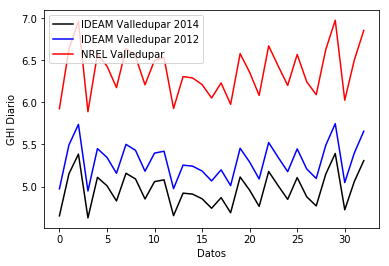

In [21]:
#VALLEDUPAR (2014 y 2012, Ajuste para un periodo de 3 meses)
grafico_ajuste('Valledupar',valledupar_IDEAM,valledupar_NREL,2014,2012,3)

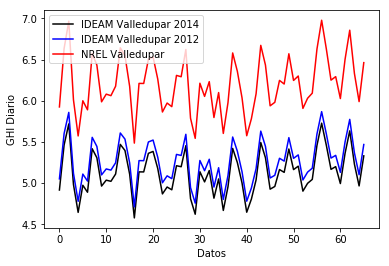

In [22]:
#VALLEDUPAR (2014 y 2012, Ajuste para un periodo de 6 meses)
grafico_ajuste('Valledupar',valledupar_IDEAM,valledupar_NREL,2014,2012,6)

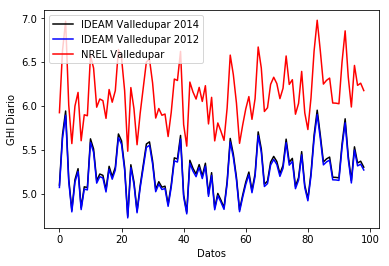

In [23]:
#VALLEDUPAR (2014 y 2012, Ajuste para un periodo de 9 meses)
grafico_ajuste('Valledupar',valledupar_IDEAM,valledupar_NREL,2014,2012,9)

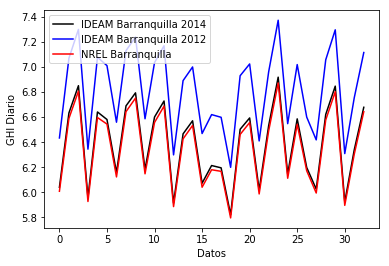

In [24]:
#BARRANQUILLA (2014 y 2012, Ajuste para un periodo de 3 meses)
grafico_ajuste('Barranquilla',barranquilla_IDEAM,barranquilla_NREL,2014,2012,3)

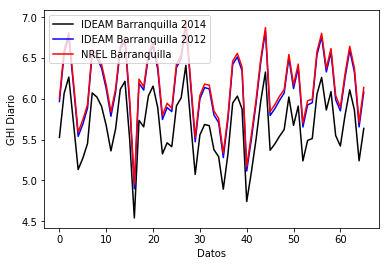

In [25]:
#BARRANQUILLA (2014 y 2012, Ajuste para un periodo de 6 meses)
grafico_ajuste('Barranquilla',barranquilla_IDEAM,barranquilla_NREL,2014,2012,6)

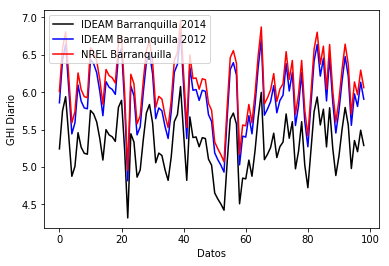

In [26]:
#BARRANQUILLA (2014 y 2012, Ajuste para un periodo de 9 meses)
grafico_ajuste('Barranquilla',barranquilla_IDEAM,barranquilla_NREL,2014,2012,9)

### Ahora se mostrará el error para la serie de 9 meses para los dos diferentes años en las dos ciudades

In [27]:
#Valledupar 2014
valledupar_IDEAM_ajustada = ajuste_mcp2(valledupar_IDEAM,valledupar_NREL,2014,9)
barranquilla_IDEAM_ajustada=ajuste_mcp2(barranquilla_IDEAM,barranquilla_NREL,2014,9)
valledupar_IDEAM_ajustada2 = ajuste_mcp2(valledupar_IDEAM,valledupar_NREL,2012,9)
barranquilla_IDEAM_ajustada2 =ajuste_mcp2(barranquilla_IDEAM,barranquilla_NREL,2012,9)
print ("El error para la serie de Valledupar (2014) es:")
print ("")
errores(valledupar_IDEAM_ajustada,valledupar_NREL)
print ("")
print ("El error para la serie de Barranquilla (2014) es:")
print ("")
errores(barranquilla_IDEAM_ajustada,barranquilla_NREL)

print ("El error para la serie de Valledupar (2012) es:")
print ("")
errores(valledupar_IDEAM_ajustada2,valledupar_NREL)
print ("")
print ("El error para la serie de Barranquilla (2012) es:")
print ("")
errores(barranquilla_IDEAM_ajustada2,barranquilla_NREL)

El error para la serie de Valledupar (2014) es:

El error de sesgo medio es:  0.16226747168685984
El error RMSE es:  0.0864996202886
El índice KSI es: Ks_2sampResult(statistic=0.5098643266118994, pvalue=0.0)

El error para la serie de Barranquilla (2014) es:

El error de sesgo medio es:  0.14617383415300297
El error RMSE es:  0.0575628260409
El índice KSI es: Ks_2sampResult(statistic=0.067909302132603155, pvalue=1.0017018066037215e-193)
El error para la serie de Valledupar (2012) es:

El error de sesgo medio es:  0.1686228260934616
El error RMSE es:  0.0967131923656
El índice KSI es: Ks_2sampResult(statistic=0.51358808397643352, pvalue=0.0)

El error para la serie de Barranquilla (2012) es:

El error de sesgo medio es:  0.026410947852615236
El error RMSE es:  0.00939741186173
El índice KSI es: Ks_2sampResult(statistic=0.012758277321384126, pvalue=3.0081681984769476e-07)


## Análisis

* De las gráficas mostradas anteriormente se puede comentar que por medio del método del ajuste mcp, los datos medidos in situ se ajustan de una forma esperada a los datos proporcionados por el satélite
* Por otro lado, se puede apreciar que a medida que se aumenta el número de meses en el periodo de ajuste de los datos medidos in situ, los datos medidos se ajustan de una mejor manera a los datos proporcionados por el satélite. Por consiguiente, se recomienda que para realizar un ajuste preciso es recomendable tener la medición in situ de varios años.
* Por último, por medio de los errores se puede decir que los datos ajustados por el ajuste mcp tienen una predicción confiable ya que los p-value son muy cercanos a 0.

In [28]:
calculo_enficc(valledupar_IDEAM)

La ENFICC 99% es:  4.56900737661
